In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

Matplotlib created a temporary config/cache directory at /var/folders/_n/4rn71s9d0kbcfsx7vgnkblrc0000gn/T/matplotlib-awpxkfhs because the default path (/Users/zhenhan/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
train = pd.read_csv("/Users/zhenhan/Desktop/深度学习/data/房屋数据（2011.8-2015.6）.csv")
train_isna = []
for col in train.columns:
    if train[col].isna().sum() / train.shape[0] > 0.4:
        train_isna.append(col)
df = train.drop(train_isna, axis=1)
df_num = df.select_dtypes(include=['int64', 'float64'])
df_obj = df.select_dtypes(include=['object'])
df_num_means = df_num.median()
df_num = df_num.fillna(df_num_means)
df_num.isna().sum().value_counts()
df_num = df_num.iloc[:,1:]
df_obj = df_obj.iloc[:,1:]
df_obj_map = {"poor":0, "no data":2, "satisfactory":2, "good":3, "excellent":4}
df_obj["ecology"] = df_obj["ecology"].map(df_obj_map)
label_encoder = LabelEncoder()
df_obj['sub_area'] = label_encoder.fit_transform(df_obj['sub_area'])
df_obj = pd.get_dummies(df_obj, columns=df_obj.columns[2:14], prefix=df_obj.columns[2:14])
df_obj = pd.get_dummies(df_obj, columns=['product_type'], prefix=['product_type'])
target_column = df_num.columns[-1]
# for col in df_num.columns:
#     correlation = df[col].corr(df[target_column])
#     if abs(correlation) <= 0.05:
#         df_num = df_num.drop(col, axis=1)
data = pd.concat([df_num, df_obj], axis=1)
X = data.drop('price_doc', axis=1)
y = data['price_doc']
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.66, random_state=42)

[LightGBM] [Info] Total Bins 65855
[LightGBM] [Info] Number of data points in the train set: 21329, number of used features: 296
[LightGBM] [Info] Start training from score 7144163.281823
Training until validation scores don't improve for 80 rounds
[20]	training's rmse: 3.12861e+06	valid_1's rmse: 3.04604e+06
[40]	training's rmse: 2.60425e+06	valid_1's rmse: 2.72049e+06
[60]	training's rmse: 2.3978e+06	valid_1's rmse: 2.64364e+06
[80]	training's rmse: 2.27366e+06	valid_1's rmse: 2.60422e+06
[100]	training's rmse: 2.18697e+06	valid_1's rmse: 2.58701e+06
[120]	training's rmse: 2.12007e+06	valid_1's rmse: 2.57831e+06
[140]	training's rmse: 2.06518e+06	valid_1's rmse: 2.57818e+06
[160]	training's rmse: 2.01716e+06	valid_1's rmse: 2.58132e+06
[180]	training's rmse: 1.97294e+06	valid_1's rmse: 2.57589e+06
[200]	training's rmse: 1.93492e+06	valid_1's rmse: 2.57676e+06
[220]	training's rmse: 1.90064e+06	valid_1's rmse: 2.57751e+06
[240]	training's rmse: 1.86758e+06	valid_1's rmse: 2.57623e+06


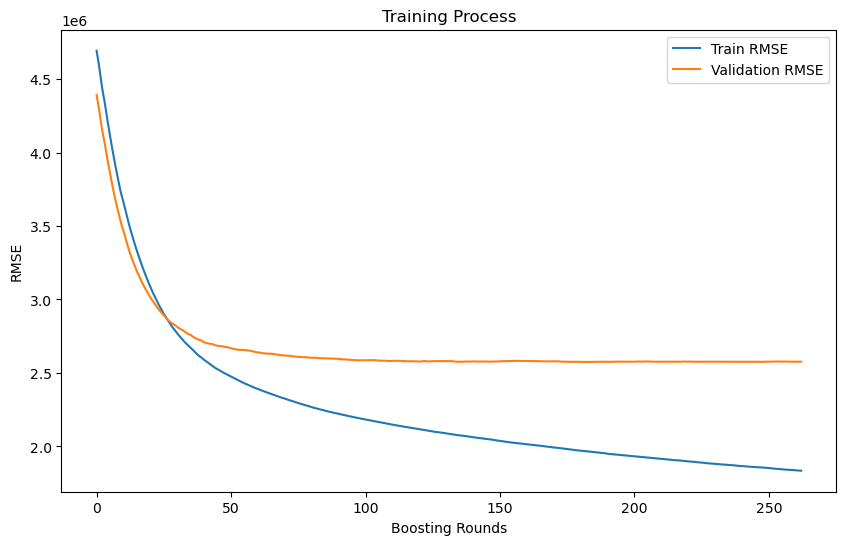

In [17]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def record_evaluation(results):
    # This callback function will be used to record evaluation results during training
    history['training']['rmse'].append(results['training']['rmse'])
    history['valid_1']['rmse'].append(results['valid_1']['rmse'])

dtrain = lgb.Dataset(data=X_train, label=y_train)
dval = lgb.Dataset(data=X_val, label=y_val, reference=dtrain)  # Set reference to dtrain for consistent validation
dtest = lgb.Dataset(data=X_test, label=y_test)

params = {
    'max_depth': -1,
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',  # ['gbdt', 'dart', 'goss', 'rf']
    'objective': 'regression',
    'metric': 'rmse',
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'num_leaves': 31,  # Set an appropriate value based on your dataset
    'max_bin': 512,
    'random_state': 42,
    'force_col_wise': True  # Use column-wise multi-threading
}

num_round = 400

history = {'training': {'rmse': []}, 'valid_1': {'rmse': []}}

callbacks = [lgb.record_evaluation(history), lgb.log_evaluation(period=20,show_stdv=True), lgb.early_stopping(stopping_rounds=80,verbose=True)]

model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=num_round,
    valid_sets=[dtrain, dval],
    callbacks=callbacks
)

predictions = model.predict(X_test)

rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.figure(figsize=(10, 6))
plt.plot(history['training']['rmse'], label='Train RMSE')
plt.plot(history['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training Process')
plt.legend()
plt.show()

In [5]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import joblib


dtrain = lgb.Dataset(data=X_train, label=y_train)
dval = lgb.Dataset(data=X_val, label=y_val, reference=dtrain)

# Define parameter grid for GridSearch

params_test1={
    'max_depth': range(7,11,1), 
    'num_leaves':range(10,90,10)  
}

params_test2={
    'max_depth': [10],
    'num_leaves':range(10,30,1)
}

params_test3={
    'max_depth': [10],
    'num_leaves': [20],
    'min_child_samples':[18,19,20,21,22,23],
    'min_child_weight':[0.001,0.002]
    } 

params_test4={
    'max_depth': [10],
    'num_leaves': [20],
    'min_child_samples':[20],
    'min_child_weight':[0.001],
    'subsample': [0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.7,0.8,0.9,1.0]  
}

params_test5={
    'max_depth': [10],
    'num_leaves': [20],
    'min_child_samples':[20],
    'min_child_weight':[0.001],
    'subsample': [0.7],
    'colsample_bytree': [1.0],
    'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3],
    'reg_lambda': [0, 0.001, 0.01, 0.03, 0.08, 0.3]
}

params_test6={
    'max_depth': [10],
    'num_leaves': [20],
    'min_child_samples':[20],
    'min_child_weight':[0.001],
    'subsample': [0.7],
    'colsample_bytree': [1.0],
    'reg_alpha': [0.01],
    'reg_lambda': [0.001],
    'boosting_type': ['gbdt'],
    'learning_rate': np.arange(0.08, 0.2, 0.02)
}

params_grid = {
    'max_depth': [10],
    'num_leaves': [20],
    'min_child_samples':[20],
    'min_child_weight':[0.001],
    'subsample': [0.7],
    'colsample_bytree': [1.0],
    'reg_alpha': [0.01],
    'reg_lambda': [0.001],
    'boosting_type': ['gbdt'],
    'learning_rate': [0.1]
}


num_round = 500
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(
                           n_estimators=num_round,
                           objective='regression', 
                           metric='rmse'),
                           param_grid=params_grid,
                           cv=5,
                           scoring=make_scorer(r2_score, greater_is_better=True),
                           verbose=2,
                           n_jobs=-1)


# Fit the model using GridSearch
callbacks = [lgb.log_evaluation(period=100, show_stdv=True), lgb.early_stopping(stopping_rounds=100, verbose=True)]
grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', callbacks=callbacks)

# Get the best model from GridSearch
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

model_filename = 'best_lgb_model.joblib'
joblib.dump(best_model, model_filename)

print(f"Trained LightGBM model saved as {model_filename}")

# Predictions and evaluation
predictions = best_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error on Validation:", rmse)

# Calculate R-squared (coefficient of determination)
r2 = r2_score(y_test, predictions)
print("R-squared on Validation:", r2)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END boosting_type=gbdt, colsample_bytree=1.0, learning_rate=0.1, max_depth=10, min_child_samples=20, min_child_weight=0.001, num_leaves=20, reg_alpha=0.01, reg_lambda=0.001, subsample=0.7; total time=   0.8s
[CV] END boosting_type=gbdt, colsample_bytree=1.0, learning_rate=0.1, max_depth=10, min_child_samples=20, min_child_weight=0.001, num_leaves=20, reg_alpha=0.01, reg_lambda=0.001, subsample=0.7; total time=   0.8s
[CV] END boosting_type=gbdt, colsample_bytree=1.0, learning_rate=0.1, max_depth=10, min_child_samples=20, min_child_weight=0.001, num_leaves=20, reg_alpha=0.01, reg_lambda=0.001, subsample=0.7; total time=   0.8s
[CV] END boosting_type=gbdt, colsample_bytree=1.0, learning_rate=0.1, max_depth=10, min_child_samples=20, min_child_weight=0.001, num_leaves=20, reg_alpha=0.01, reg_lambda=0.001, subsample=0.7; total time=   0.7s
[CV] END boosting_type=gbdt, colsample_bytree=1.0, learning_rate=0.1, max_depth=10, min_c

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhenhan/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhenhan/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/zhenhan/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/zhenhan/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/lightgbm/engine.py", line 302, in train
    cb(callback.CallbackEnv(model=booster,
  File "/Users/zhenhan/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/lightgbm/callback.py", line 256, in _callback
    _init(env)
  File "/Users/zhenhan/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/lightgbm/callback.py", line 226, in _init
    raise ValueError('For early stopping, '
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation
